In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Load data
# Load data

pd_data = pd.read_csv('../../datasets/auto-mpg.csv')

# Handle missing values marked as '?'
pd_data = pd_data.replace("?", np.nan)  
pd_data = pd_data.dropna()  

# Convert categorical variables to numeric using label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_columns = pd_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    pd_data[col] = le.fit_transform(pd_data[col])

# Convert horsepower to float
pd_data = pd_data.astype({"horsepower": float})

# Prepare features and target
X = pd_data.drop(columns=['mpg'])
y = pd_data['mpg']


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test) 
r2_socre_ = r2_score(y_test, preds)
print(r2_socre_)
rmse_score = np.sqrt(np.mean((y_test - preds) ** 2))
print(rmse_score)

0.886177057582073
2.410308977514835


In [ ]:
import sys
sys.path.append("../../")
train_preds = rf.predict(X_train)

min_index = np.argmin(train_preds)  # min val index
max_index = np.argmax(train_preds)  # max val index
mean_value = np.mean(train_preds)   # mean val 

closest_mean_index = np.argmin(np.abs(train_preds - mean_value))  # 找到最接近均值的索引


# Define function f(x) using rf.predict.
def f(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf.predict(x_df)[0])


#run experiments
from Approach import run_search_path
prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
prototype_labels = y_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
each_step_avg_errs = []
No_path_index = []
for i in range(1,len(X_test)):
    try:
        error, avg_step_error = run_search_path(f, prototypes, prototype_labels, X_test.iloc[i].values)
        print("error:", i, error, 'error means', np.array(avg_step_error).mean() / preds.mean())       
        if error is not None:
            Errors.append(error)
            each_step_avg_errs.append(avg_step_error)
        else:
            No_path_index.append(i)
    except Exception as e:
        print(f"Error at index {i}: {e}, skipping this iteration.")
        continue

X_proto [4.000e+00 1.510e+02 7.900e+01 2.855e+03 1.760e+01 7.800e+01 1.000e+00
 2.040e+02] org_proto 23.451 label 23.8
X_proto [4.000e+00 1.210e+02 9.000e+00 2.795e+03 1.570e+01 7.800e+01 2.000e+00
 2.550e+02] pred_prototype adj 23.507
X_target [4.000e+00 1.210e+02 9.000e+00 2.795e+03 1.570e+01 7.800e+01 2.000e+00
 2.550e+02] pred_target 23.507
Found a path:
Step 0: x = [4.000e+00 1.210e+02 9.000e+00 2.795e+03 1.570e+01 7.800e+01 2.000e+00
 2.550e+02], f(x) = 23.507
error: 1 0.0 error means 0.0
X_proto [4.000e+00 9.000e+01 4.900e+01 2.085e+03 2.170e+01 8.000e+01 2.000e+00
 2.990e+02] org_proto 43.719000000000044 label 44.3
X_proto [   4.    91.    49.  2085.    21.7   80.     3.   299. ] pred_prototype adj 43.02300000000004
X_target [   4.    91.    55.  1800.    16.4   78.     3.   169. ] pred_target 34.927999999999976


In [8]:
np.array(each_step_avg_errs).mean() / preds.mean()

0.06445111106310662

In [12]:
len(Errors) /len(X_test)

0.9746835443037974

In [11]:
len(X_test)

79

In [9]:
X_train.iloc[min_index]

cylinders          8.0
displacement     304.0
horsepower        39.0
weight          4732.0
acceleration      18.5
model year        70.0
origin             1.0
car name         161.0
Name: 28, dtype: float64

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
# Define our function f(x) using rf.predict.
# def f(x):
#     x_df = pd.DataFrame([x], columns=X.columns)
#     return float(rf.predict(x_df)[0])

def f(x):
    # 支持单个样本和批量样本
    if x.ndim == 1:
        x = x.reshape(1, -1)
    x_df = pd.DataFrame(x, columns=X.columns)
    return rf.predict(x_df).astype(float)

In [6]:
from sklearn.cluster import KMeans
def dynamic_feature_filter(x_proto, x_target, num_samples=10, threshold=0.1):
    """
    classify features as low- or high-sensitivity by computing
    the variance of predictions when varying each feature, and then clustering 
    the variances using k-means.
    
    Parameters:
      x_proto: 1D numpy array for the prototype.
      x_target: 1D numpy array for the target.
      num_samples: Number of interpolation points per feature.
    
    Returns:
      variances: Array of variance values for each feature.
      low_variance_features: List of indices of features with low sensitivity.
      high_variance_features: List of indices of features with high sensitivity.
    """
    x_proto_adj = np.copy(x_proto)
    n_features = len(x_proto)
    variances = np.zeros(n_features)
    low_variance_features = []
    high_variance_features = []
    for i in range(n_features):
        # Generate interpolation values for the i-th feature.
        interp_vals = np.linspace(x_proto[i], x_target[i], num_samples)
        preds = []
        for val in interp_vals:
            x_temp = np.copy(x_proto)
            x_temp[i] = val  # Vary only the i-th feature.
            preds.append(f(x_temp))
        preds = np.array(preds)
        var_val = np.var(preds)
        variances[i] = var_val
        if var_val < threshold:
          x_proto_adj[i] = x_target[i]
          low_variance_features.append(i)
        else:
          high_variance_features.append(i)
    return x_proto_adj, variances, low_variance_features, high_variance_features


In [7]:
# Grid generation that fixes low-variance features.
def generate_grid_with_filter(x_proto_adj, x_target, partitions, low_variance_features):
    """
    For low-variance features, use a grid with a single point (the target).
    For high-variance features, generate a grid between x_proto_adj and x_target.
    """
    grid = []
    n_features = len(x_proto_adj)
    for i in range(n_features):
        if i in low_variance_features:
            grid.append(np.array([x_target[i]]))
        else:
            grid.append(np.linspace(x_proto_adj[i], x_target[i], partitions + 1))
    return grid

In [9]:
import numpy as np
import pandas as pd
import heapq
from collections import deque


def local_linear_error(x_start, x_end, f_start, f_end, num_samples=10):
    """
    Compute the average squared error between the true function f(x)
    and its linear interpolation between (x_start, f_start) and (x_end, f_end)
    """
    t_vals = np.linspace(0, 1, num_samples)
    error_sum = 0.0
    for t in t_vals:
        x_interp = x_start + t * (x_end - x_start)
        f_interp = f_start + t * (f_end - f_start)
        f_actual = f(x_interp)
        error_sum += abs(f_actual - f_interp)
    return error_sum
# def local_linear_error(x_start, x_end, f_start, f_end, num_samples=10):
#     """批量计算线性插值误差"""
#     t_vals = np.linspace(0, 1, num_samples)
#     # 批量生成插值点
#     x_interp = x_start + np.outer(t_vals, (x_end - x_start))
#     f_interp = f_start + t_vals * (f_end - f_start)
#     f_actual = f(x_interp)
#     return np.mean((f_actual - f_interp) ** 2)

def heuristic(current_x, target_x, current_f, target_f, num_samples=10):
    """
    A simple heuristic: the local linear error from the current point to the target.
    This is admissible if f is reasonably smooth.
    """
    return local_linear_error(current_x, target_x, current_f, target_f, num_samples)
def a_star_search(initial_state, initial_x, f_proto, target_x, f_target, grid, max_steps, monotonic_increasing, tol=1e-6):
    """
    A* search in the discretized feature space.
    """
    # Get the actual number of partitions for each dimension
    partitions = [len(grid[i]) - 1 for i in range(len(grid))]
    d = len(initial_state)
    counter = 0
    
    # Each item in the heap is a tuple: (estimated_total_cost, cumulative_error, state, path, f_values, steps)
    start_item = (heuristic(initial_x, target_x, f_proto, f_target), 0.0,counter, initial_state, [initial_x], [f_proto], 0)
    heap = [start_item]
    best_solution = None
    visited = {}  # records the best cumulative error reached for a given state

    while heap:
        est_cost, cum_error, counter, state, path, f_values, steps = heapq.heappop(heap)
        
        # Skip if we've seen this state with a lower cost already
        if state in visited and visited[state] <= cum_error:
            continue
        visited[state] = cum_error
        
        # Check if we've reached the target state
        # print("state")
        if all(state[i] == partitions[i] for i in range(d)):
            best_solution = {'path': path, 'f_values': f_values, 'error': cum_error}
            break
        
        # If maximum steps have been reached, update the best solution if it's better
        if steps >= max_steps:
            if best_solution is None or cum_error < best_solution['error']:
                best_solution = {'path': path, 'f_values': f_values, 'error': cum_error}
            continue

        current_x = np.array([grid[i][state[i]] for i in range(d)])
        current_f = f_values[-1]
        
        # Expand the current state: try to update one feature at a time
        for i in range(d):
            if state[i] < partitions[i]:  # Check against dimension-specific partition size
                # Allow stepping 1 to the remaining number of grid points in dimension i
                for step_size in range(1, partitions[i] - state[i] + 1):
                    new_state = list(state)
                    new_state[i] += step_size
                    new_state = tuple(new_state)
                    
                    new_x = np.array([grid[j][new_state[j]] for j in range(d)])
                    # new_f = f(new_x)
                    
                    # # Check monotonicity constraints (with tolerance)
                    # if monotonic_increasing and new_f < current_f - tol:
                    #     continue
                    # if not monotonic_increasing and new_f > current_f + tol:
                    #     continue
                    # Check monotonicity constraints (with tolerance)
                    new_f = float(f(new_x)[0])  # Convert to scalar
                    current_f = float(current_f)  # Ensure current_f is also scalar
                    
                    # Check monotonicity constraints (with tolerance)
                    if monotonic_increasing and new_f < current_f - tol:
                        continue
                    if not monotonic_increasing and new_f > current_f + tol:
                        continue
                  
                    
                    
                    
                    local_err = local_linear_error(current_x, new_x, current_f, new_f)
                    new_cum_error = cum_error + local_err
                    
                    # Compute heuristic from new state to target
                    h = heuristic(new_x, target_x, new_f, f_target)
                  
                    # new_est_cost = new_cum_error + h
                    new_est_cost = float(new_cum_error + h)
                    new_path = path + [new_x]
                    new_f_values = f_values + [new_f]
                    # print("1",new_est_cost, new_cum_error, new_state, new_path, new_f_values)
                    counter += 1
                    # heapq.heappush(heap, (new_est_cost, new_cum_error, counter, new_state, new_path, new_f_values, steps + 1))
                    heapq.heappush(heap, (new_est_cost, new_cum_error, counter, new_state, new_path, new_f_values, steps + 1))
                    
    return best_solution



In [10]:
def run_search_path(prototypes, X_target,partitions=2,max_steps=5):
    # Choose a test instance to explain (e.g., the first one)
    f_target = f(X_target)
    # Define multiple prototype candidates
    # Compute distances to X_target
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    # Select the closest prototype
    closest_proto_index = np.argmin(distances)
    X_proto = prototypes[closest_proto_index]
    #### identify noise directions
    x_proto_adj, variances, low_variance_features, high_variance_features = dynamic_feature_filter(X_proto, X_target)
    grid = generate_grid_with_filter(x_proto_adj, X_target, partitions, low_variance_features)
    
    
    d = len(X_proto)
    initial_state = tuple([0] * d)
    initial_x = np.array([grid[i][0] for i in range(d)])  # 与 x_proto 应相同
    f_proto = f(initial_x)
    f_target = f(X_target)
    # identify the monotonic direction
    monotonic_increasing = (f_target >= f_proto)

    print("X_proto",X_proto, 'org_proto', f(X_proto))
    print("X_proto",x_proto_adj, 'pred_prototype adj', f(x_proto_adj))
    print("X_target",X_target,'pred_target', f_target)
    # result = dfs(initial_state, [initial_x], [f_proto], 0.0, grid, max_steps, monotonic_increasing, tol=1e-6)
    result = a_star_search(initial_state, initial_x, f_proto, X_target, f_target, grid, max_steps, monotonic_increasing)
    #


    if result is not None:
        print("Found a path:")
        for i, (x_val, fx_val) in enumerate(zip(result['path'], result['f_values'])):
            print(f"Step {i}: x = {x_val}, f(x) = {fx_val}")
        print("Cumulative error:", result['error'])
        return result['error']
    else:
        print("No path found.")
        return None
    

In [16]:
prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
No_path_index = []

for i in range(len(X_test)):
    if i==48:
        continue
    if i==70:
        continue
    error = run_search_path(prototypes,X_test.iloc[i].values)
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
    else:
        No_path_index.append(i)   

X_proto [4.000e+00 9.000e+01 4.900e+01 2.085e+03 2.170e+01 8.000e+01 2.000e+00
 2.990e+02] org_proto [43.719]
X_proto [4.000e+00 9.000e+01 4.900e+01 2.085e+03 2.170e+01 8.000e+01 2.000e+00
 2.990e+02] pred_prototype adj [43.719]
X_target [4.000e+00 9.600e+01 6.400e+01 2.189e+03 1.800e+01 7.200e+01 2.000e+00
 2.510e+02] pred_target [26.02]
Found a path:
Step 0: x = [4.000e+00 9.000e+01 4.900e+01 2.085e+03 2.170e+01 8.000e+01 2.000e+00
 2.990e+02], f(x) = [43.719]
Step 1: x = [4.000e+00 9.000e+01 4.900e+01 2.137e+03 2.170e+01 8.000e+01 2.000e+00
 2.990e+02], f(x) = 43.63500000000003
Step 2: x = [4.000e+00 9.000e+01 4.900e+01 2.137e+03 2.170e+01 8.000e+01 2.000e+00
 2.750e+02], f(x) = 42.068000000000005
Step 3: x = [4.000e+00 9.000e+01 4.900e+01 2.137e+03 2.170e+01 8.000e+01 2.000e+00
 2.510e+02], f(x) = 42.00200000000001
Step 4: x = [4.000e+00 9.000e+01 4.900e+01 2.189e+03 2.170e+01 8.000e+01 2.000e+00
 2.510e+02], f(x) = 41.166000000000004
Step 5: x = [4.000e+00 9.000e+01 5.650e+01 2.18

KeyboardInterrupt: 

In [18]:
np.array(Errors).mean() / preds.mean()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([0.34623458])

In [11]:
X_test.iloc[51]

cylinders          4.0
displacement     113.0
horsepower        89.0
weight          2278.0
acceleration      15.5
model year        72.0
origin             3.0
car name         268.0
Name: 57, dtype: float64

In [12]:
def baseline_one_step(prototypes, f, X_target, avg_abs_pred, num_points=10):
    """
    Baseline 1: Linear Model with Fixed Intercept fitted using inserted data.
    
    This function selects the prototype closest to X_target, then generates a set
    of interpolation points between that prototype (x_start) and X_target (x_end). 
    It fits a linear model with the intercept fixed to f(x_start) (i.e., the function 
    value at the prototype) by estimating the slope using least squares on all inserted points.
    The predicted endpoint is computed as f(x_start) + slope, and the cumulative error 
    is calculated using the linear_approximation_error function.
    
    Args:
        prototypes (np.ndarray): Array of prototype instances.
        f (callable): Function to evaluate.
        X_target (np.ndarray): Target instance.
        avg_abs_pred (float): Average absolute prediction value for normalization.
        num_points (int): Number of interpolation points.
    
    Returns:
        tuple: (raw_cumulative_error, normalized_cumulative_error)
    """
    import numpy as np

    # Select the closest prototype to X_target.
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    closest_proto_index = np.argmin(distances)
    x_start = prototypes[closest_proto_index]
    x_end = X_target
    
    # Generate trajectory of points between X_proto and X_target.
    path = np.array([x_start + (x_end - x_start) * (i / (num_points - 1)) for i in range(num_points)])
    
    # Evaluate the function on the trajectory.
    f_values = np.array([f(x) for x in path])
    
    X_features = path - x_start              # shape: (num_points, d)
    Y_targets = f_values - f_values[0]         # shape: (num_points,)
    w, residuals, rank, s = np.linalg.lstsq(X_features, Y_targets, rcond=None)
    predictions = f_values[0] + np.dot((path - x_start), w)

    # Cumulative absolute error
    raw_cumulative_error = np.sum(np.abs(f_values - predictions))
    normalized_cumulative_error = raw_cumulative_error / avg_abs_pred
    
    errors = np.abs(f_values - predictions)
    
    
    # print("Linear Model Fitted using Inserted Data:")
    # for i, (x_val, actual, pred) in enumerate(zip(path, f_values, predictions)):
    #     print(f"Step {i}: x = {x_val}, f(x) = {actual}, prediction = {pred}")
    print("Raw Cumulative Error:", raw_cumulative_error)
    print("error:",errors)
    print("Normalized Cumulative Error:", normalized_cumulative_error)
    
    return raw_cumulative_error, normalized_cumulative_error


In [10]:
def baseline1run(prototypes, X_target, avg_abs_pred, num_points=10):
    """
    Baseline 1: Linear Interpolation.
    
    Constructs a straight-line trajectory between the closest prototype (to X_target)
    and the target instance. The trajectory consists of num_points evenly spaced points.
    The cumulative error is computed as the sum of absolute differences between the 
    function values along the trajectory and f(X_target). The error is then normalized.
    
    Args:
        prototypes (np.ndarray): Array of prototype instances.
        X_target (np.ndarray): Target instance.
        avg_abs_pred (float): Average absolute prediction value for normalization.
        num_points (int): Number of interpolation points.
    
    Returns:
        tuple: (raw_cumulative_error, normalized_cumulative_error)
    """
    # Select the closest prototype to X_target.
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    closest_proto_index = np.argmin(distances)
    X_proto = prototypes[closest_proto_index]
    
    # Create the linear interpolation trajectory.
    path = [X_proto + (X_target - X_proto) * (i / (num_points - 1)) for i in range(num_points)]
    
    f_target = f(X_target)
    f_values = [f(x) for x in path]
    
    # Compute the cumulative error along the trajectory.
    raw_cumulative_error = sum(abs(val - f_target) for val in f_values)
    normalized_cumulative_error = raw_cumulative_error / avg_abs_pred
    
    print("Linear Interpolation (Baseline 1) Path:")
    for i, (x_val, fx_val) in enumerate(zip(path, f_values)):
        print(f"Step {i}: x = {x_val}, f(x) = {fx_val}")
    print("Raw Cumulative Error:", raw_cumulative_error)
    print("Normalized Cumulative Error:", normalized_cumulative_error)
    
    return raw_cumulative_error, normalized_cumulative_error

In [14]:
prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
Norm_Errors= []
No_path_index = []
for i in range(len(X_test)):
    error, norm_error = baseline_one_step(prototypes,f,X_test.iloc[i].values,preds.mean())
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
        Norm_Errors.append(norm_error)
    else:
        No_path_index.append(i) 

Raw Cumulative Error: 19.78274736842107
error: [[0.        ]
 [0.13908421]
 [0.63216842]
 [5.91425263]
 [4.57733684]
 [2.19242105]
 [0.46050526]
 [0.02441053]
 [1.57332632]
 [4.26924211]]
Normalized Cumulative Error: 0.8553058253906547
error: 0 19.78274736842107
Raw Cumulative Error: 0.8674666666666759
error: [[0.        ]
 [0.08707719]
 [0.21815439]
 [0.05223158]
 [0.02530877]
 [0.03338596]
 [0.23253684]
 [0.08945965]
 [0.09061754]
 [0.03869474]]
Normalized Cumulative Error: 0.03750486621067531
error: 1 0.8674666666666759
Raw Cumulative Error: 13.478196491228246
error: [[0.        ]
 [1.43010877]
 [1.36921754]
 [3.62132632]
 [2.01543509]
 [1.32654386]
 [0.05865263]
 [0.1107614 ]
 [1.06112982]
 [2.48502105]]
Normalized Cumulative Error: 0.5827289688341953
error: 2 13.478196491228246
Raw Cumulative Error: 25.200715789473872
error: [[0.        ]
 [1.00009474]
 [1.82518947]
 [5.98328421]
 [4.95037895]
 [2.89747368]
 [1.09756842]
 [0.54633684]
 [2.45324211]
 [4.44714737]]
Normalized Cumula

In [15]:
np.array(Norm_Errors).mean()

0.3972588856873689

In [13]:
# Prediction function using your random forest model.
def f(x):
    """
    Predicts the value for x using a random forest model.
    
    Args:
        x (np.ndarray): Input feature vector.
    
    Returns:
        float: Predicted value.
    """
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf.predict(x_df)[0])

# Finite difference gradient approximation for f(x).
def grad_f(x, delta=1e-6):
    """
    Approximates the gradient of f at x using finite differences.
    
    Args:
        x (np.ndarray): Input feature vector.
        delta (float): Small perturbation used to compute the finite difference.
    
    Returns:
        np.ndarray: Approximated gradient vector.
    """
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_forward = np.array(x, copy=True)
        x_backward = np.array(x, copy=True)
        x_forward[i] += delta
        x_backward[i] -= delta
        grad[i] = (f(x_forward) - f(x_backward)) / (2 * delta)
    return grad

def baseline2run(prototypes, X_target, avg_abs_pred, p, max_steps=5, tol=1e-6):
    """
    Baseline 2: Gradient Descent-Based Search using a finite difference approximation.
    
    This function starts from the prototype that is closest to the target and performs
    gradient descent with an update rule:
    
        x_{t+1} = x_t - (1/p) * grad_f(x_t)
    
    The process stops when the current point is within a tolerance of X_target or after a
    maximum number of steps.
    
    Args:
        prototypes (np.ndarray): Array of prototype instances.
        X_target (np.ndarray): Target instance.
        avg_abs_pred (float): Average absolute prediction value for normalization.
        p (float): Parameter that scales the gradient step (step size is 1/p).
        max_steps (int): Maximum number of gradient descent steps.
        tol (float): Tolerance for convergence toward X_target.
    
    Returns:
        tuple: (raw_cumulative_error, normalized_cumulative_error)
    """
    # Find the prototype closest to the target.
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    closest_proto_index = np.argmin(distances)
    X_proto = prototypes[closest_proto_index]
    
    f_target = f(X_target)
    path = [X_proto.copy()]
    f_values = [f(X_proto)]
    x_current = X_proto.copy()
    
    for step in range(max_steps):
        # Approximate the gradient at the current point.
        grad = grad_f(x_current)
        # Update the current point.
        x_new = x_current - (1 / p) * grad
        path.append(x_new.copy())
        f_values.append(f(x_new))
        
        # Check if the new point is close enough to the target.
        if np.linalg.norm(x_new - X_target) < tol:
            break
        
        x_current = x_new
    
    raw_cumulative_error = sum(abs(val - f_target) for val in f_values)
    normalized_cumulative_error = raw_cumulative_error / avg_abs_pred
    
    print("Gradient Descent-Based Search (Baseline 2) Path:")
    for i, (x_val, fx_val) in enumerate(zip(path, f_values)):
        print(f"Step {i}: x = {x_val}, f(x) = {fx_val}")
    print("Raw Cumulative Error:", raw_cumulative_error)
    print("Normalized Cumulative Error:", normalized_cumulative_error)
    
    return raw_cumulative_error, normalized_cumulative_error

prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
Norm_Errors= []
No_path_index = []
for i in range(len(X_test)):
    error, norm_error = baseline2run(prototypes,X_test.iloc[i].values,preds.mean(),2)
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
        Norm_Errors.append(norm_error)
    else:
        No_path_index.append(i) 
        
print(np.array(Norm_Errors).mean())

Gradient Descent-Based Search (Baseline 2) Path:
Step 0: x = [4.000e+00 9.000e+01 4.900e+01 2.085e+03 2.170e+01 8.000e+01 2.000e+00
 2.990e+02], f(x) = 43.719000000000044
Step 1: x = [   4.    90.    49.  2085.    21.7   80.  -498.   299. ], f(x) = 43.719000000000044
Step 2: x = [   4.    90.    49.  2085.    21.7   80.  -498.   299. ], f(x) = 43.719000000000044
Step 3: x = [   4.    90.    49.  2085.    21.7   80.  -498.   299. ], f(x) = 43.719000000000044
Step 4: x = [   4.    90.    49.  2085.    21.7   80.  -498.   299. ], f(x) = 43.719000000000044
Step 5: x = [   4.    90.    49.  2085.    21.7   80.  -498.   299. ], f(x) = 43.719000000000044
Raw Cumulative Error: 106.19400000000026
Normalized Cumulative Error: 4.591290841964826
error: 0 106.19400000000026
Gradient Descent-Based Search (Baseline 2) Path:
Step 0: x = [4.000e+00 1.510e+02 7.900e+01 2.855e+03 1.760e+01 7.800e+01 1.000e+00
 2.040e+02], f(x) = 23.451
Step 1: x = [4.000e+00 1.510e+02 7.900e+01 2.855e+03 1.760e+01 7.800e

In [12]:
np.array(norm_error).mean()

1.8537843704062908

In [ ]:
error = run_search_path(prototypes,X_test.iloc[i].values)

In [33]:
prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
No_path_index = []

Errors = [0.22916227037037423,
 0.0,
 0.6736127111111194,
 3.742809488888878,
 0.10403256296296302,
 1.0327779777777888,
 0.0190871703703705,
 0.2586942259259283,
 0.08259511111111065,
 1.5953026481481816,
 0.08495706296296296,
 0.020594192592593156,
 0.259376370370369,
 0.1201323259259254,
 0.12718117037037005,
 4.439875822222238,
 0.08621143333333404,
 0.3852815518518502,
 1.7985502962962987,
 0.7609020333333324,
 0.09234291481481556,
 0.055900429629628476,
 1.0167767518518653,
 0.8909458740740779,
 1.152274137037037,
 0.20984899259259635,
 0.057173862962965075,
 0.10768147037037072,
 4.020706674074061,
 0.12502508148148175,
 0.07390438518518433,
 0.06746284444444353,
 2.45649244814816,
 0.076107933333333,
 0.4970397296296483,
 0.1111818518518521,
 3.808565518518555,
 0.13458851851851916,
 0.0,
 0.12608407407407418,
 1.9953386000000102,
 0.06503049629629548,
 0.2893609629629624,
 0.11775074074074084,
 0.005509600000000052,
 0.39519658148148185,
 1.1950222333333491,
 0.9946646666666747,
 0.038718796296296425,
 0.26033688148148476,
 0.2682731925925905,
 1.4962322851851912,
 0.23162799629629485,
 0.18972003333333246,
 0.18286622962963012,
 0.3377287518518516,
 0.4393800888888882,
 0.0046503407407407675,
 0.1115544592592604,
 0.0,
 0.08347692962963052,
 0.4898298111111157,
 0.06529739629629734,
 1.7112182518518562,
 0.05421955925925949,
 0.07849808518518539]
for i in range(70, len(X_test)):
    if i==48:
        continue
    if i==70:
        continue
    error = run_search_path(prototypes,X_test.iloc[i].values)
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
    else:
        No_path_index.append(i) 
    

X_proto [8.000e+00 3.040e+02 3.900e+01 4.732e+03 1.850e+01 7.000e+01 1.000e+00
 1.610e+02] org_proto [10.456]
X_proto [8.000e+00 3.500e+02 3.600e+01 4.732e+03 1.850e+01 7.300e+01 1.000e+00
 2.400e+01] pred_prototype adj [12.126]
X_target [8.0e+00 3.5e+02 3.6e+01 4.1e+03 1.3e+01 7.3e+01 1.0e+00 2.4e+01] pred_target [13.81]
Found a path:
Step 0: x = [8.000e+00 3.500e+02 3.600e+01 4.732e+03 1.850e+01 7.300e+01 1.000e+00
 2.400e+01], f(x) = [12.126]
Step 1: x = [8.000e+00 3.500e+02 3.600e+01 4.732e+03 1.300e+01 7.300e+01 1.000e+00
 2.400e+01], f(x) = 12.57
Step 2: x = [8.0e+00 3.5e+02 3.6e+01 4.1e+03 1.3e+01 7.3e+01 1.0e+00 2.4e+01], f(x) = 13.81
Cumulative error: 0.036338618518518696
error: 71 0.036338618518518696
X_proto [4.000e+00 1.510e+02 7.900e+01 2.855e+03 1.760e+01 7.800e+01 1.000e+00
 2.040e+02] org_proto [23.451]
X_proto [   4.   146.    91.  2815.    14.5   77.     3.    88. ] pred_prototype adj [23.367]
X_target [   6.   146.    91.  2815.    14.5   77.     3.    88. ] pred_tar

In [32]:
Errors

[0.22916227037037423,
 0.0,
 0.6736127111111194,
 3.742809488888878,
 0.10403256296296302,
 1.0327779777777888,
 0.0190871703703705,
 0.2586942259259283,
 0.08259511111111065,
 1.5953026481481816,
 0.08495706296296296,
 0.020594192592593156,
 0.259376370370369,
 0.1201323259259254,
 0.12718117037037005,
 4.439875822222238,
 0.08621143333333404,
 0.3852815518518502,
 1.7985502962962987,
 0.7609020333333324,
 0.09234291481481556,
 0.055900429629628476,
 1.0167767518518653,
 0.8909458740740779,
 1.152274137037037,
 0.20984899259259635,
 0.057173862962965075,
 0.10768147037037072,
 4.020706674074061,
 0.12502508148148175,
 0.07390438518518433,
 0.06746284444444353,
 2.45649244814816,
 0.076107933333333,
 0.4970397296296483,
 0.1111818518518521,
 3.808565518518555,
 0.13458851851851916,
 0.0,
 0.12608407407407418,
 1.9953386000000102,
 0.06503049629629548,
 0.2893609629629624,
 0.11775074074074084,
 0.005509600000000052,
 0.39519658148148185,
 1.1950222333333491,
 0.9946646666666747,
 0.038

<AxesSubplot:ylabel='Count'>

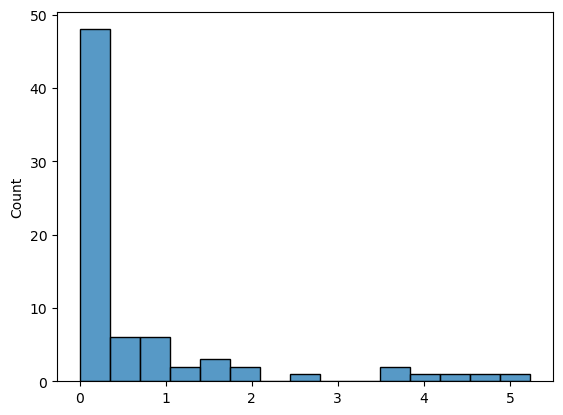

In [34]:
import seaborn as sns
sns.histplot(Errors)

In [36]:
len(X_test)

79

In [35]:
len(Errors)

74

In [37]:
np.array(Errors).mean()

0.7201942426426453